In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../../../data/Df with State Rank plus binned columns.csv',index_col="Unnamed: 0")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Coordinates,School District,State Rank
0,7129300520,10/13/2014,221900.0,small,minimal,1180,5650,1.0,NaN,0.0,...,1955,0.0,98178,47.5112,-122.257,1340,5650,"(-122.257, 47.5112)",seattle,11-50
1,6414100192,12/9/2014,538000.0,small,minimal,2570,7242,2.0,0.0,0.0,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,"(-122.319, 47.721000000000004)",seattle,11-50
2,5631500400,2/25/2015,180000.0,small,minimal,770,10000,1.0,0.0,0.0,...,1933,NaN,98028,47.7379,-122.233,2720,8062,"(-122.23299999999999, 47.7379)",northshore,Top_ten
3,2487200875,12/9/2014,604000.0,small,average,1960,5000,1.0,0.0,0.0,...,1965,0.0,98136,47.5208,-122.393,1360,5000,"(-122.39299999999999, 47.5208)",seattle,11-50
4,1954400510,2/18/2015,510000.0,small,minimal,1680,8080,1.0,0.0,0.0,...,1987,0.0,98074,47.6168,-122.045,1800,7503,"(-122.045, 47.6168)",lake washington,Top_ten


In [3]:
df = df.drop_duplicates()

In [4]:
df.date = df["date"].map(lambda x: x.split("/")[0])

In [5]:
df['date'] = df['date'].map(lambda x: int(x))

In [6]:
df.waterfront = df.waterfront.replace(np.NaN, 0.0)

In [7]:
df = df.fillna(0.0)

In [8]:
df.columns = df.columns.str.replace(" ", "_")

In [9]:
df.columns = df.columns.str.lower().str.replace(".0", "")

In [11]:
df_corr_price = df.corr()['price'].map(abs).sort_values(ascending=False)
df_corr_price

price            1.000000
sqft_living      0.700673
sqft_above       0.603899
sqft_living15    0.585329
view             0.394476
lat              0.306950
waterfront       0.263315
floors           0.259331
yr_renovated     0.119919
sqft_lot         0.088113
sqft_lot15       0.080797
yr_built         0.049736
zipcode          0.049642
id               0.019255
long             0.018177
date             0.009518
Name: price, dtype: float64

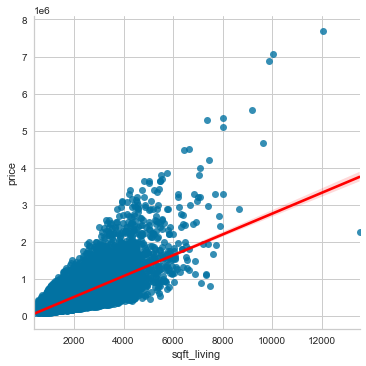

In [14]:
sns.lmplot(x='sqft_living', y='price', data=df, line_kws={'color': 'red'})
plt.show();

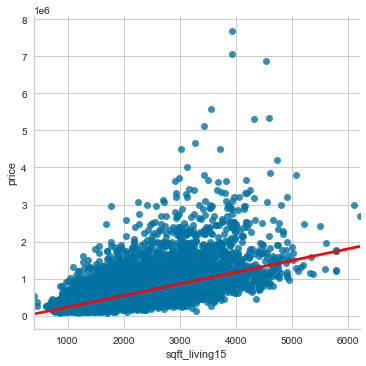

In [15]:
sns.lmplot(x='sqft_living15', y='price', data=df, line_kws={'color': 'red'})
plt.show();

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21234 entries, 0 to 21233
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               21234 non-null  int64  
 1   date             21234 non-null  int64  
 2   price            21234 non-null  float64
 3   bedrooms         21234 non-null  object 
 4   bathrooms        21234 non-null  object 
 5   sqft_living      21234 non-null  int64  
 6   sqft_lot         21234 non-null  int64  
 7   floors           21234 non-null  float64
 8   waterfront       21234 non-null  float64
 9   view             21234 non-null  float64
 10  condition        21234 non-null  object 
 11  grade            21234 non-null  object 
 12  sqft_above       21234 non-null  int64  
 13  sqft_basement    21234 non-null  object 
 14  yr_built         21234 non-null  int64  
 15  yr_renovated     21234 non-null  float64
 16  zipcode          21234 non-null  int64  
 17  lat         

In [17]:
dropped_columns = ['school_district', 'coordinates',
                  'sqft_lot', 'sqft_lot15', 'sqft_living15', 'long', 'zipcode', 'yr_renovated',
                  'yr_built', 'sqft_basement', 'grade', 'condition', 'view', 'floors',
                  'bedrooms', 'id', 'date', 'price']

In [18]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
predictors = df.drop(columns=dropped_columns)
predict= '+'.join(predictors)
f = 'price ~' + predict
model_df = ols(formula=f, data=df).fit()
model_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     4231.
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:28:49   Log-Likelihood:            -2.9207e+05
No. Observations:               21234   AIC:                         5.842e+05
Df Residuals:                   21225   BIC:                         5.842e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -3.413e+07    5.4e+05    -63.217      0.000   -3.52e+07   -3.31e+07
bathrooms[T.many]       9.381e+05   5.32e+04     17.632      0.000    8.34e+05    1.04e+06
bathrooms[T.minimal]   -1.034e+05   5659.605    -18.265      0.000   -1.14e+05   -9.23e+04
state_rank[T.51-above]  -922.5169   4139.621     -0.223      0.824   -9036.488    7191.454
state_rank[T.Top_ten]    128.0513   3541.303      0.036      0.971   -6813.171    7069.274
sqft_living              228.7270      3.752     60.954      0.000     221.372     236.082
waterfront              8.728e+05   1.91e+04     45.680      0.000    8.35e+05     9.1e+05
sqft_above                16.4125      3.939      4.166      0.000       8.691      24.134
lat                     7.201e+05   1.13e+04     63.472      0.000    6.98e+05    7.42e+05
==============================================================================
Omnibus:                    13746.579   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           523323.418
Skew:                           2.571   Prob(JB):                         0.00
Kurtosis:                      26.771   Cond. No.                     1.03e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.03e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
dropped_columns_new = ['school_district', 'coordinates',
                  'sqft_lot', 'sqft_lot15', 'long', 'zipcode', 'yr_renovated',
                  'yr_built', 'view', 'floors', 'id', 'date']

In [20]:
df = df.drop(columns=dropped_columns_new)

In [21]:
df.head()

,price,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,state_rank
0,221900.0,small,minimal,1180,0.0,good,good,1180,0.0,47.5112,1340,11-50
1,538000.0,small,minimal,2570,0.0,good,good,2170,400.0,47.7210,1690,11-50
2,180000.0,small,minimal,770,0.0,good,bad,770,0.0,47.7379,2720,Top_ten
3,604000.0,small,average,1960,0.0,very_good,good,1050,910.0,47.5208,1360,11-50
4,510000.0,small,minimal,1680,0.0,good,good,1680,0.0,47.6168,1800,Top_ten


In [22]:
df["sqft_basement"] = df["sqft_basement"].replace("0.0", np.nan)
df["sqft_basement"] = df["sqft_basement"].replace("?", np.nan)
df["sqft_basement"] = df["sqft_basement"].fillna(0.0)
df["sqft_basement"] = df["sqft_basement"].map(lambda x: float(x))

In [23]:
while df["sqft_basement"].loc[df["sqft_basement"] == 0].count() > 0:
    for i in range(0, len(df)):
        if df["sqft_basement"].iloc[i] == 0:
            df["sqft_basement"].iloc[i] = 0.1

C:\Users\Catherine\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Lower Price Model

In [24]:
df_low_price_pre = df.loc[df['price']< 300000]
df_low_price_pre

,price,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,state_rank
0,221900.0,small,minimal,1180,0.0,good,good,1180,0.1,47.5112,1340,11-50
2,180000.0,small,minimal,770,0.0,good,bad,770,0.1,47.7379,2720,Top_ten
6,257500.0,small,minimal,1715,0.0,good,good,1715,0.1,47.3097,2238,51-above
7,291850.0,small,minimal,1060,0.0,good,good,1060,0.1,47.4095,1650,51-above
8,229500.0,small,minimal,1780,0.0,good,good,1050,730.0,47.5123,1780,51-above
...,...,...,...,...,...,...,...,...,...,...,...,...
21168,295000.0,small,minimal,1230,0.0,good,good,1230,0.1,47.4380,1440,51-above
21195,274800.0,small,minimal,1410,0.0,good,good,1410,0.1,47.5171,1410,11-50
21199,269950.0,small,minimal,2244,0.0,good,good,2244,0.1,47.2606,2077,11-50
21219,288790.0,small,minimal,1290,0.0,good,good,1060,230.0,47.5400,1370,51-above


In [25]:
df_low_price_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4374 entries, 0 to 21228
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4374 non-null   float64
 1   bedrooms       4374 non-null   object 
 2   bathrooms      4374 non-null   object 
 3   sqft_living    4374 non-null   int64  
 4   waterfront     4374 non-null   float64
 5   condition      4374 non-null   object 
 6   grade          4374 non-null   object 
 7   sqft_above     4374 non-null   int64  
 8   sqft_basement  4374 non-null   float64
 9   lat            4374 non-null   float64
 10  sqft_living15  4374 non-null   int64  
 11  state_rank     4374 non-null   object 
dtypes: float64(4), int64(3), object(5)
memory usage: 444.2+ KB


In [26]:
continuous = ["sqft_above", "price",'sqft_living']

categorical = ['bedrooms',"grade",'condition',"bathrooms","state_rank"]

df_log = np.log(df_low_price_pre[continuous])
df_log.columns = [f"{column}_log" for column in df[continuous]]

    
df_norm = (np.log(df_low_price_pre[continuous]) - np.mean(np.log(df_low_price_pre[continuous])))/np.std(np.log(df_low_price_pre[continuous]))
df_norm.columns = [f"{column}_log" for column in df_low_price_pre[continuous]]

df_ohe = pd.get_dummies(df_low_price_pre[categorical], columns=categorical, drop_first = True)

df_low_price = pd.concat([df_norm, df_ohe], axis = 1)
#df_low_price = pd.concat([df_final1,df_low_price_pre.drop(columns=['price', 'bedrooms', 'bathrooms', 'sqft_living', 'waterfront','condition', 'grade',
 #      'sqft_above', 'sqft_basement', 'lat', 'sqft_living15'])], axis=1)

In [27]:
df_low_price.columns

Index(['sqft_above_log', 'price_log', 'sqft_living_log', 'bedrooms_small',
       'grade_good', 'condition_good', 'condition_very_good',
       'bathrooms_minimal', 'state_rank_51-above', 'state_rank_Top_ten'],
      dtype='object')

In [28]:
X_low = df_low_price.drop(columns=['price_log'], axis=1) 
y_low = df_low_price[['price_log']]
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(X_low, y_low, random_state=50, test_size=.25)

In [29]:
f = y_train_low, X_train_low
model_low = ols(formula=f, data=X_train_low).fit()
model_low.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.199
Model:                            OLS   Adj. R-squared (uncentered):              0.197
Method:                 Least Squares   F-statistic:                              90.31
Date:                Thu, 01 Jul 2021   Prob (F-statistic):                   1.26e-150
Time:                        16:32:02   Log-Likelihood:                         -4280.9
No. Observations:                3280   AIC:                                      8580.
Df Residuals:                    3271   BIC:                                      8635.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sqft_above_log         -0.0023      0.027     -0.084      0.933      -0.055       0.051
sqft_living_log         0.3326      0.029     11.595      0.000       0.276       0.389
bedrooms_small          0.0503      0.092      0.547      0.584      -0.130       0.230
grade_good              0.3095      0.040      7.679      0.000       0.231       0.389
condition_good          0.3886      0.091      4.262      0.000       0.210       0.567
condition_very_good     0.4150      0.092      4.486      0.000       0.234       0.596
bathrooms_minimal      -0.6240      0.110     -5.686      0.000      -0.839      -0.409
state_rank_51-above    -0.0358      0.041     -0.872      0.383      -0.116       0.045
state_rank_Top_ten     -0.0553      0.035     -1.561      0.119      -0.125       0.014
==============================================================================
Omnibus:                      575.098   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1156.414
Skew:                          -1.048   Prob(JB):                    7.72e-252
Kurtosis:                       5.017   Cond. No.                         17.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
df_low_price.corr()['price_log'].map(abs).sort_values(ascending=False)

price_log              1.000000
sqft_living_log        0.420262
sqft_above_log         0.345996
grade_good             0.340750
bathrooms_minimal      0.052673
bedrooms_small         0.049395
condition_good         0.047501
state_rank_Top_ten     0.014289
condition_very_good    0.004450
state_rank_51-above    0.001702
Name: price_log, dtype: float64

In [31]:
linreg_low = LinearRegression()
linreg_low.fit(X_train_low, y_train_low)

predicted_y_low = linreg_low.predict(X_test_low) 

linreg_low.score(X_test_low, y_test_low)

0.21706970934378256

In [32]:
lr_low = LinearRegression()

In [33]:
lr_low.fit(X_train_low, y_train_low)

LinearRegression()

In [34]:
from sklearn.model_selection import KFold

folds = KFold(5, shuffle = True)
train_train_scores = []
train_test_scores = []
train_train_rmse = []
train_test_rmse = []
for train_ind, test_ind in folds.split(X_train_low):
    X_train_low_train = X_train_low.iloc[train_ind]
    X_train_low_test = X_train_low.iloc[test_ind]
    y_train_low_train = y_train_low.iloc[train_ind]
    y_train_low_test = y_train_low.iloc[test_ind]
    linreg_low1 = LinearRegression()
    linreg_low1.fit(X_train_low_train, y_train_low_train)
    train_train_scores.append(linreg_low1.score(X_train_low_train, y_train_low_train))
    train_test_scores.append(linreg_low1.score(X_train_low_test, y_train_low_test))
    train_train_rmse.append(np.sqrt(mse(y_train_low_train, linreg_low1.predict(X_train_low_train))))
    train_test_rmse.append(np.sqrt(mse(y_train_low_test, linreg_low1.predict(X_train_low_test))))
    

In [35]:
train_test_scores

[0.16018645389890918,
 0.21423732365779424,
 0.22391952150734107,
 0.25908760956165056,
 0.16666304230312712]

In [36]:
train_train_scores

[0.21874302137253154,
 0.2057219621242492,
 0.20226785717997964,
 0.19689812231407067,
 0.21734436341024244]

In [37]:
train_train_rmse

[0.8842949038150546,
 0.8898261629636555,
 0.8693723705443406,
 0.9092453002353599,
 0.8834001773932603]

In [38]:
train_test_rmse

[0.9016685889490266,
 0.8794560016470117,
 0.9577049631928801,
 0.7953167208140937,
 0.9052400181426385]

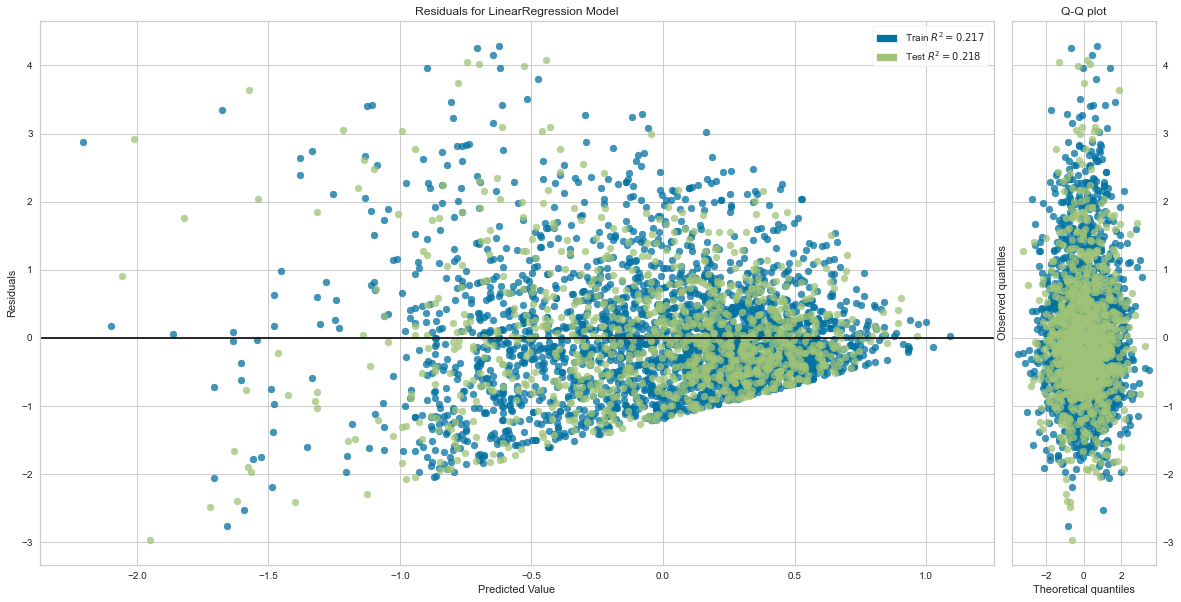

In [60]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_low = ResidualsPlot(linreg_low1, hist=False, qqplot=True)
visualizer_low.fit(X_train_low_train, y_train_low_train)
visualizer_low.score(X_test_low, y_test_low)
visualizer_low.show();
# plt.savefig('Linear Regression Model Lower plus QQ plot.png', dpi=300)

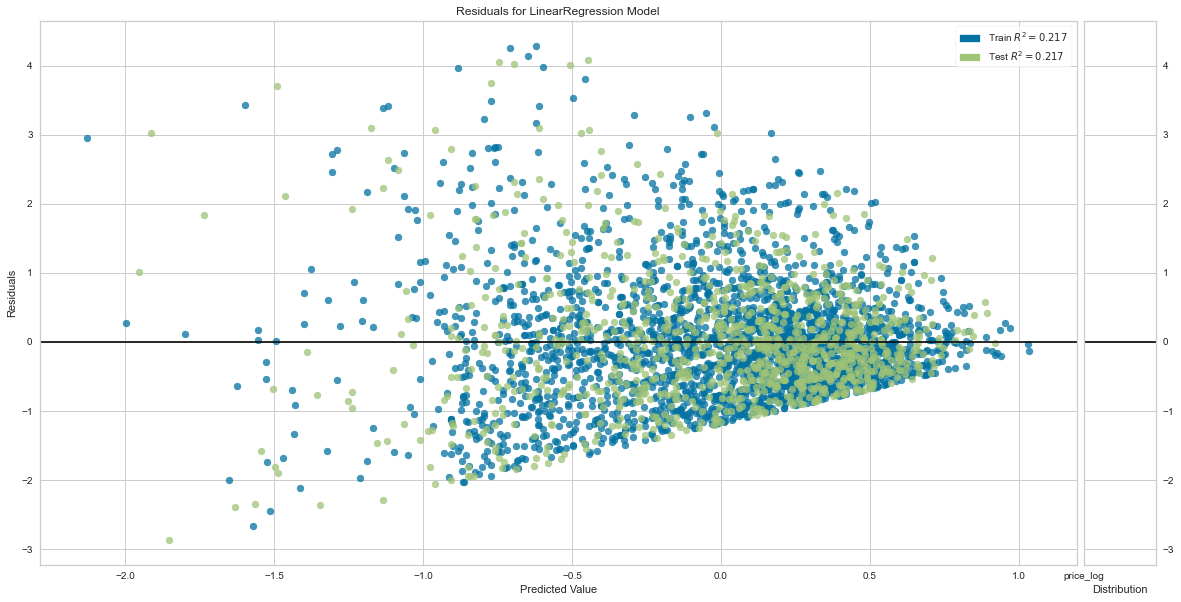

In [61]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_low = ResidualsPlot(lr_low)
visualizer_low.fit(X_train_low_train, y_train_low_train)
visualizer_low.score(X_test_low, y_test_low)
visualizer_low.show();
# plt.savefig('Linear Regression Model Lower Price.png', dpi=300)

## Middle Price Model

In [41]:
df_middle_price_pre = df.loc[(300000 <= df['price']) & (df['price'] < 650000)]
df_middle_price_pre.head()

,price,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,state_rank
1,538000.0,small,minimal,2570,0.0,good,good,2170,400.0,47.7210,1690,11-50
3,604000.0,small,average,1960,0.0,very_good,good,1050,910.0,47.5208,1360,11-50
4,510000.0,small,minimal,1680,0.0,good,good,1680,0.1,47.6168,1800,Top_ten
9,323000.0,small,minimal,1890,0.0,good,good,1890,0.1,47.3684,2390,Top_ten
11,468000.0,small,minimal,1160,0.0,very_good,good,860,300.0,47.6900,1330,11-50


In [42]:
df_middle_price_pre.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'waterfront',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat',
       'sqft_living15', 'state_rank'],
      dtype='object')

In [43]:
continuous = ["sqft_above", "price", "sqft_living15","sqft_living","lat"]

categorical = ['bathrooms',"grade","state_rank"]

df_log = np.log(df_middle_price_pre[continuous])
df_log.columns = [f"{column}_log" for column in df[continuous]]

    
df_norm = (np.log(df_middle_price_pre[continuous]) - np.mean(np.log(df_middle_price_pre[continuous])))/np.std(np.log(df_middle_price_pre[continuous]))
df_norm.columns = [f"{column}_log" for column in df_low_price_pre[continuous]]

df_ohe = pd.get_dummies(df_middle_price_pre[categorical], columns=categorical, drop_first = True)

df_middle_price = pd.concat([df_norm, df_ohe], axis = 1)
#df_middle_price = pd.concat([df_final1,df_middle_price_pre.drop(columns=['price', 'bedrooms', 'bathrooms', 'sqft_living', 'waterfront','condition', 'grade',
 #      'sqft_above', 'sqft_basement', 'lat', 'sqft_living15'])], axis=1)

In [44]:
df_middle_price.columns

Index(['sqft_above_log', 'price_log', 'sqft_living15_log', 'sqft_living_log',
       'lat_log', 'bathrooms_many', 'bathrooms_minimal', 'grade_good',
       'grade_very_good', 'state_rank_51-above', 'state_rank_Top_ten'],
      dtype='object')

In [45]:
X_middle = df_middle_price.drop(columns=['price_log'], axis=1) 
y_middle = df_middle_price[['price_log']]
X_train_middle, X_test_middle, y_train_middle, y_test_middle = train_test_split(X_middle, y_middle, random_state=50, test_size=.25)

In [46]:
f = y_train_middle, X_train_middle
model_mid = ols(formula=f, data=X_train_middle).fit()
model_mid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.265
Model:                            OLS   Adj. R-squared (uncentered):              0.264
Method:                 Least Squares   F-statistic:                              314.0
Date:                Thu, 01 Jul 2021   Prob (F-statistic):                        0.00
Time:                        16:36:11   Log-Likelihood:                         -11013.
No. Observations:                8718   AIC:                                  2.205e+04
Df Residuals:                    8708   BIC:                                  2.212e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sqft_above_log         -0.0212      0.016     -1.337      0.181      -0.052       0.010
sqft_living15_log       0.1766      0.012     14.191      0.000       0.152       0.201
sqft_living_log         0.2887      0.017     17.496      0.000       0.256       0.321
lat_log                 0.4402      0.010     44.186      0.000       0.421       0.460
bathrooms_many         -0.5142      0.607     -0.848      0.397      -1.703       0.675
bathrooms_minimal      -0.1487      0.027     -5.424      0.000      -0.202      -0.095
grade_good              0.1651      0.028      5.986      0.000       0.111       0.219
grade_very_good         0.8363      0.099      8.448      0.000       0.642       1.030
state_rank_51-above    -0.0274      0.024     -1.144      0.253      -0.074       0.020
state_rank_Top_ten     -0.0192      0.020     -0.939      0.348      -0.059       0.021
==============================================================================
Omnibus:                      393.210   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.191
Skew:                           0.009   Prob(JB):                     6.03e-36
Kurtosis:                       2.332   Cond. No.                         107.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
df_middle_price.corr()['price_log'].map(abs).sort_values(ascending=False)

price_log              1.000000
lat_log                0.284231
sqft_living_log        0.278744
sqft_living15_log      0.250014
sqft_above_log         0.191565
grade_good             0.122791
bathrooms_minimal      0.104270
grade_very_good        0.098606
bathrooms_many         0.006894
state_rank_Top_ten     0.006713
state_rank_51-above    0.001165
Name: price_log, dtype: float64

In [49]:
linreg_mid = LinearRegression()
linreg_mid.fit(X_train_middle, y_train_middle)

predicted_y_middle = linreg_mid.predict(X_test_middle) 

linreg_mid.score(X_test_middle, y_test_middle)

0.256954683643581

In [50]:
lr_middle = LinearRegression()

In [51]:
lr_middle.fit(X_train_middle, y_train_middle)

LinearRegression()

In [52]:
folds2 = KFold(5, shuffle = True)
train_train_scores_mid = []
train_test_scores_mid = []
train_train_rmse_mid = []
train_test_rmse_mid = []
for train_ind_mid, test_ind_mid in folds2.split(X_train_middle):
    X_train_mid_train = X_train_middle.iloc[train_ind_mid]
    X_train_mid_test = X_train_middle.iloc[test_ind_mid]
    y_train_mid_train = y_train_middle.iloc[train_ind_mid]
    y_train_mid_test = y_train_middle.iloc[test_ind_mid]
    linreg_mid = LinearRegression()
    linreg_mid.fit(X_train_mid_train, y_train_mid_train)
    train_train_scores_mid.append(linreg_mid.score(X_train_mid_train, y_train_mid_train))
    train_test_scores_mid.append(linreg_mid.score(X_train_mid_test, y_train_mid_test))
    train_train_rmse_mid.append(np.sqrt(mse(y_train_mid_train, linreg_mid.predict(X_train_mid_train))))
    train_test_rmse_mid.append(np.sqrt(mse(y_train_mid_test, linreg_mid.predict(X_train_mid_test))))

In [53]:
train_train_scores_mid

[0.2674865541037901,
 0.2638291908632956,
 0.2649384592877293,
 0.2658890595706157,
 0.2632480219113079]

In [54]:
train_test_scores_mid

[0.2516919870979897,
 0.2686146978763855,
 0.26458034302829736,
 0.2602830387666293,
 0.26918932803957296]

In [55]:
train_train_rmse_mid

[0.854848737790603,
 0.8537856061535221,
 0.8558580308499544,
 0.8586655733670581,
 0.8553971035606396]

In [56]:
train_test_rmse_mid

[0.8602705740689064,
 0.8641484529080884,
 0.8558825252259709,
 0.844466863765123,
 0.8579430762611626]

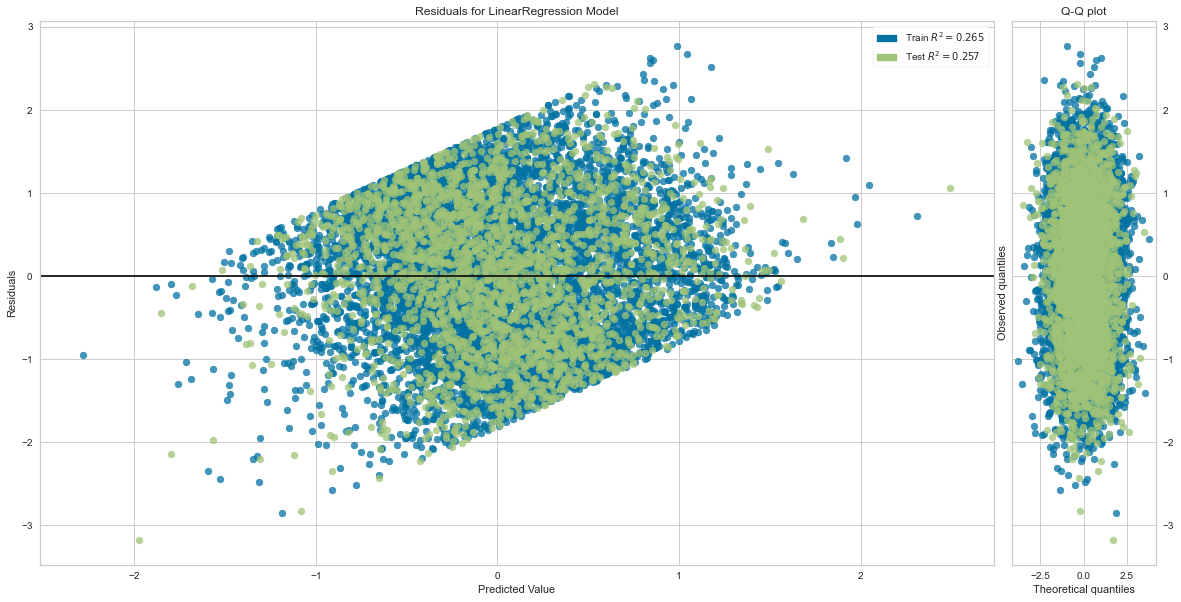

In [57]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_middle = ResidualsPlot(lr_middle, hist=False, qqplot=True)
visualizer_middle.fit(X_train_middle, y_train_middle)
visualizer_middle.score(X_test_middle, y_test_middle)
visualizer_middle.show();
# plt.savefig('Linear Regression Model Middle Price plus QQ plot.png', dpi=300)

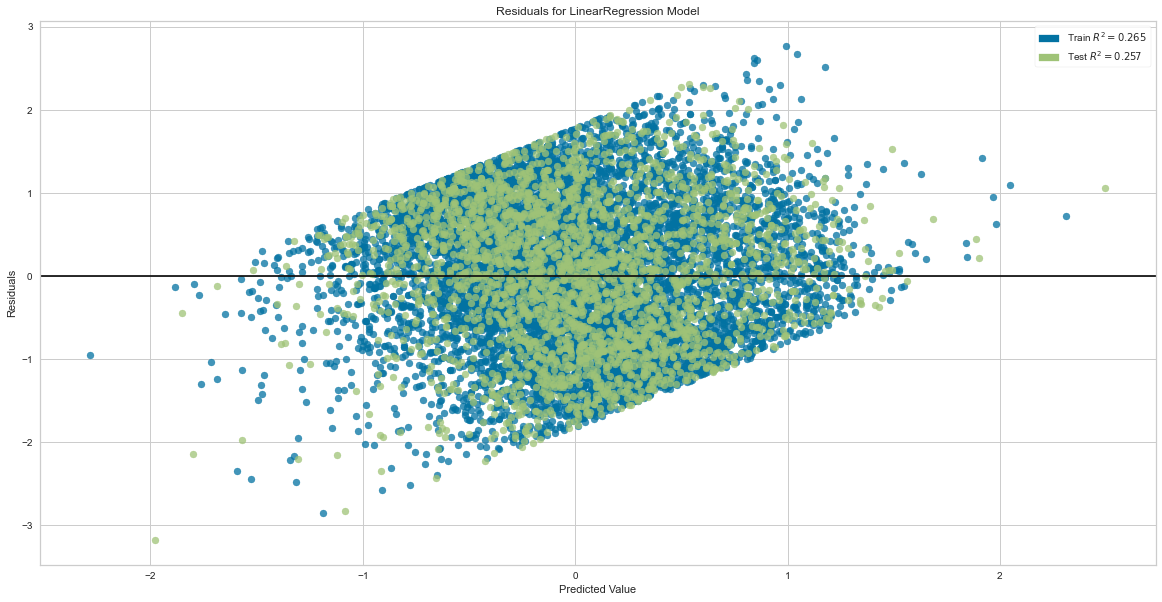

In [58]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_middle = ResidualsPlot(lr_middle, hist=False)
visualizer_middle.fit(X_train_middle, y_train_middle)
visualizer_middle.score(X_test_middle, y_test_middle)
visualizer_middle.show();
# plt.savefig('Linear Regression Model Middle Price.png', dpi=300)

## Higher Price Model

In [62]:
df_higher_price = df.loc[df['price']>= 650000]
df_higher_price

,price,bedrooms,bathrooms,sqft_living,waterfront,condition,grade,sqft_above,sqft_basement,lat,sqft_living15,state_rank
5,1230000.0,small,average,5420,0.0,good,very_good,3890,1530.0,47.6561,4760,Top_ten
10,662500.0,small,minimal,3560,0.0,good,good,1860,1700.0,47.6007,2210,Top_ten
15,650000.0,small,average,2950,0.0,good,good,1980,970.0,47.5714,2140,11-50
21,2000000.0,small,minimal,3050,0.0,good,good,2330,720.0,47.5316,4110,Top_ten
26,937000.0,small,minimal,2450,0.0,good,good,1750,700.0,47.6386,1760,11-50
...,...,...,...,...,...,...,...,...,...,...,...,...
21221,869950.0,small,minimal,3140,0.0,good,good,3140,0.1,47.5923,3500,Top_ten
21226,750000.0,small,minimal,2810,0.0,good,good,2810,0.1,47.7081,2990,51-above
21227,729999.0,small,minimal,1630,0.0,good,very_good,1330,300.0,47.6113,1570,11-50
21232,890000.0,moderate,average,4100,0.0,good,very_good,4100,0.1,47.5955,3710,Top_ten


In [63]:
df_higher_price.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'waterfront',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat',
       'sqft_living15', 'state_rank'],
      dtype='object')

In [69]:
continuous = ["sqft_above", "price", "sqft_basement","sqft_living"]

categorical = ['bathrooms',"grade","state_rank", "waterfront"]

df_log = np.log(df_middle_price_pre[continuous])
df_log.columns = [f"{column}_log" for column in df[continuous]]

    
df_norm = (np.log(df_middle_price_pre[continuous]) - np.mean(np.log(df_middle_price_pre[continuous])))/np.std(np.log(df_middle_price_pre[continuous]))
df_norm.columns = [f"{column}_log" for column in df_low_price_pre[continuous]]

df_ohe = pd.get_dummies(df_middle_price_pre[categorical], columns=categorical, drop_first = True)

df_higher_price = pd.concat([df_norm, df_ohe], axis = 1)

In [70]:
df_higher_price.columns

Index(['sqft_above_log', 'price_log', 'sqft_basement_log', 'sqft_living_log',
       'bathrooms_many', 'bathrooms_minimal', 'grade_good', 'grade_very_good',
       'state_rank_51-above', 'state_rank_Top_ten', 'waterfront_1.0'],
      dtype='object')

In [71]:
X_higher = df_higher_price.drop(columns=['price_log'], axis=1) 
y_higher = df_higher_price[['price_log']]
X_train_higher, X_test_higher, y_train_higher, y_test_higher = train_test_split(X_higher, y_higher, random_state=50, test_size=.25)

In [72]:
f = y_train_higher, X_train_higher
model_high = ols(formula=f, data=X_train_higher).fit()
model_high.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              price_log   R-squared (uncentered):                   0.095
Model:                            OLS   Adj. R-squared (uncentered):              0.094
Method:                 Least Squares   F-statistic:                              91.60
Date:                Thu, 01 Jul 2021   Prob (F-statistic):                   9.16e-181
Time:                        16:45:26   Log-Likelihood:                         -11919.
No. Observations:                8718   AIC:                                  2.386e+04
Df Residuals:                    8708   BIC:                                  2.393e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
sqft_above_log          0.1515      0.037      4.065      0.000       0.078       0.225
sqft_basement_log       0.1670      0.023      7.301      0.000       0.122       0.212
sqft_living_log         0.0867      0.035      2.487      0.013       0.018       0.155
bathrooms_many         -0.0978      0.673     -0.145      0.884      -1.417       1.221
bathrooms_minimal      -0.1765      0.031     -5.749      0.000      -0.237      -0.116
grade_good              0.2076      0.031      6.733      0.000       0.147       0.268
grade_very_good         0.7216      0.110      6.562      0.000       0.506       0.937
state_rank_51-above    -0.0468      0.027     -1.758      0.079      -0.099       0.005
state_rank_Top_ten     -0.0288      0.023     -1.268      0.205      -0.073       0.016
waterfront_1.0          0.3733      0.238      1.568      0.117      -0.093       0.840
==============================================================================
Omnibus:                     1618.881   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.389
Skew:                          -0.072   Prob(JB):                     4.48e-75
Kurtosis:                       2.040   Cond. No.                         92.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
df_higher_price.corr()['price_log'].map(abs).sort_values(ascending=False)

price_log              1.000000
sqft_living_log        0.278744
sqft_above_log         0.191565
sqft_basement_log      0.137560
grade_good             0.122791
bathrooms_minimal      0.104270
grade_very_good        0.098606
waterfront_1.0         0.014695
bathrooms_many         0.006894
state_rank_Top_ten     0.006713
state_rank_51-above    0.001165
Name: price_log, dtype: float64

In [74]:
linreg_high = LinearRegression()
linreg_high.fit(X_train_higher, y_train_higher)

predicted_y_higher = linreg_high.predict(X_test_higher) 

linreg_high.score(X_test_higher, y_test_higher)

0.09924716684668122

In [75]:
lr_higher = LinearRegression()

In [76]:
lr_higher.fit(X_train_higher, y_train_higher)

LinearRegression()

In [77]:
folds3 = KFold(5, shuffle = True)
train_train_scores_high = []
train_test_scores_high = []
train_train_rmse_high = []
train_test_rmse_high = []
for train_ind_high, test_ind_high in folds3.split(X_train_higher):
    X_train_high_train = X_train_higher.iloc[train_ind_high]
    X_train_high_test = X_train_higher.iloc[test_ind_high]
    y_train_high_train = y_train_higher.iloc[train_ind_high]
    y_train_high_test = y_train_higher.iloc[test_ind_high]
    linreg_high = LinearRegression()
    linreg_high.fit(X_train_high_train, y_train_high_train)
    train_train_scores_high.append(linreg_high.score(X_train_high_train, y_train_high_train))
    train_test_scores_high.append(linreg_high.score(X_train_high_test, y_train_high_test))
    train_train_rmse_high.append(np.sqrt(mse(y_train_high_train, linreg_high.predict(X_train_high_train))))
    train_test_rmse_high.append(np.sqrt(mse(y_train_high_test, linreg_high.predict(X_train_high_test))))

In [78]:
train_train_scores_high

[0.09579488883482601,
 0.09495820750075001,
 0.0937169680957215,
 0.10311514604092153,
 0.09415258340253652]

In [79]:
train_test_scores_high

[0.09638542643213277,
 0.10012943961568266,
 0.10476113635823492,
 0.06623237012985494,
 0.10290546944847301]

In [80]:
train_train_rmse_high

[0.9475538676945495,
 0.9491442605071228,
 0.9502109247512475,
 0.9475419993199541,
 0.9500361507885169]

In [81]:
train_test_rmse_high

[0.9553129095556833,
 0.9488569416518609,
 0.9447310387587075,
 0.9554657842978711,
 0.9455210569957284]

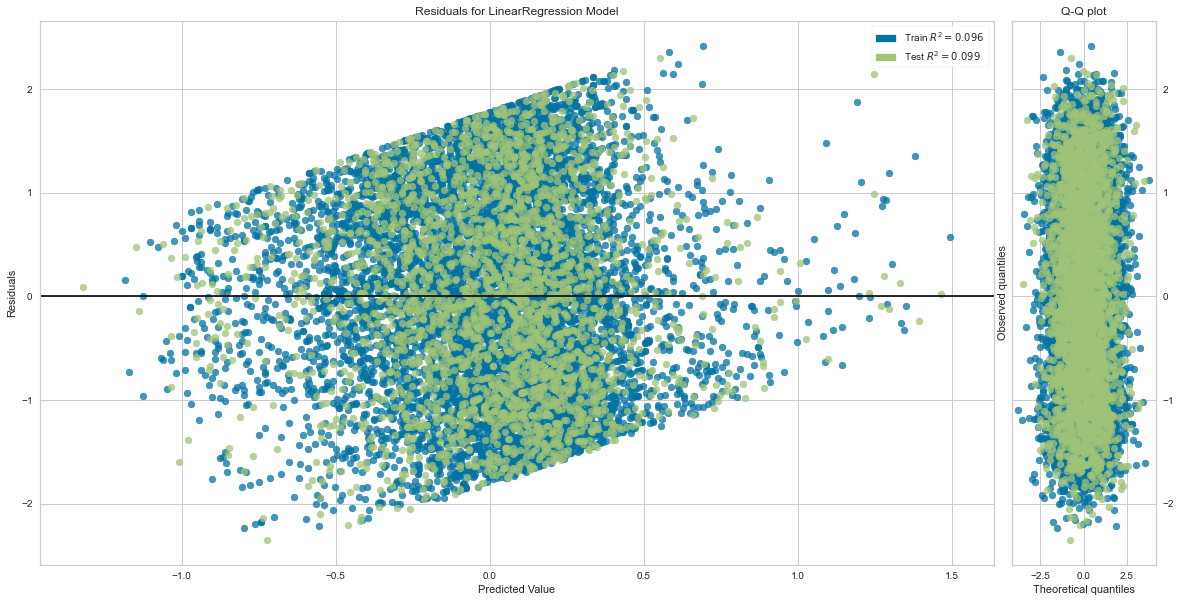

In [82]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_higher = ResidualsPlot(lr_higher, hist=False, qqplot=True)
visualizer_higher.fit(X_train_higher, y_train_higher)
visualizer_higher.score(X_test_higher, y_test_higher)
visualizer_higher.show();
# plt.savefig('Linear Regression Model Higher Price plus QQ plot.png',dpi=300);

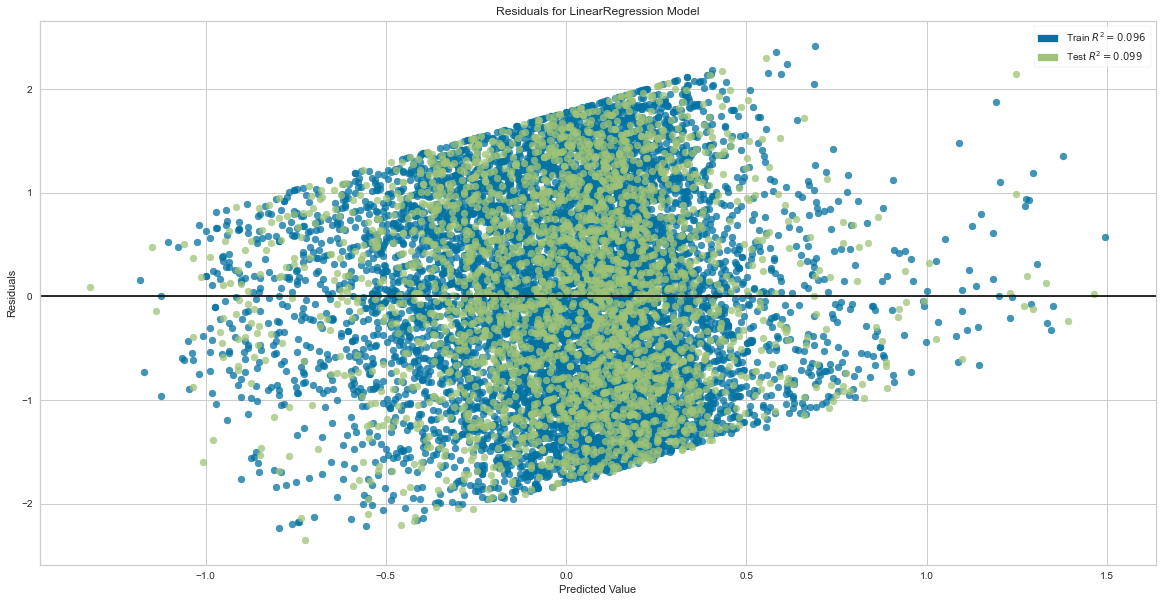

In [83]:
fig, ax = plt.subplots(figsize = (20,10))
visualizer_higher = ResidualsPlot(lr_higher, hist=False)
visualizer_higher.fit(X_train_higher, y_train_higher)
visualizer_higher.score(X_test_higher, y_test_higher)
visualizer_higher.show();
# plt.savefig('Linear Regression Model High Price.png')